In [22]:
import numpy as np, pandas as pd, pickle
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer

In [23]:
df = pd.read_csv('./merged-data.csv')
df = df.drop('year',axis=1)
values_to_replace = [9999.99, 99999.9, 999.999, 9999999.0]
df.replace(values_to_replace, np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)

In [24]:
df.head()

,month,day,hour,bx_gsm,by_gsm,bz_gsm,bt,speed,density,temp,intensity,declination,inclination,north,east,vertical,horizontal
0,6,8,1,11.17,1.35,3.37,16.80,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
1,6,8,2,10.45,0.69,2.84,17.14,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
2,6,8,3,7.73,1.32,3.12,16.26,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
3,6,8,4,8.73,0.80,2.66,17.11,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289
4,6,8,5,7.84,1.28,1.80,20.58,431.352471,6.906209,110481.874291,57265,85.373,89.711,23,288,57264,289


In [25]:
# Strategy to fill missing values
imputer = SimpleImputer(strategy='mean')

# Impute the missing values for all columns
df[df.columns] = imputer.fit_transform(df[df.columns])

# Save the imputer to a file using pickle
with open('simple_imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

In [26]:
#scaler = MinMaxScaler()
scaler =StandardScaler()

columns_to_scale = [
    'month', 'day', 'hour','bx_gsm', 'by_gsm', 'bz_gsm', 'bt','speed', 'density', 'temp',
    'intensity','declination', 'inclination', 'north','east', 'vertical', 'horizontal'
]
 
# Apply the scaler to each column in the list
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Display the first few rows of the DataFrame
print(df.head())

      month       day      hour  ...      east  vertical  horizontal
0 -0.151583 -0.883816 -1.517247  ...  1.695851 -1.691384    1.696862
1 -0.151583 -0.883816 -1.372752  ...  1.695851 -1.691384    1.696862
2 -0.151583 -0.883816 -1.228256  ...  1.695851 -1.691384    1.696862
3 -0.151583 -0.883816 -1.083761  ...  1.695851 -1.691384    1.696862
4 -0.151583 -0.883816 -0.939266  ...  1.695851 -1.691384    1.696862

[5 rows x 17 columns]


In [27]:
# Save the scaler to a file using pickle
with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [28]:
k_range = range(1,15)
sse = []
for i in k_range:
    clusterer = KMeans(n_clusters=i)
    clusterer.fit(df[df.columns.values])
    sse.append(clusterer.inertia_)


In [29]:
for err in sse:
    print(err)
print()
print("min:",np.min(sse))

603687.0000000002
423853.99417385657
383875.0195179984
347800.57963312033
323913.53712552413
308139.06512350426
297327.1140651393
287345.84126848605
276181.7199137997
273125.1183293639
266550.08469292725
258074.5700956265
252985.49306900945
248042.36592784134

min: 248042.36592784134


Text(0.5, 0, 'k')

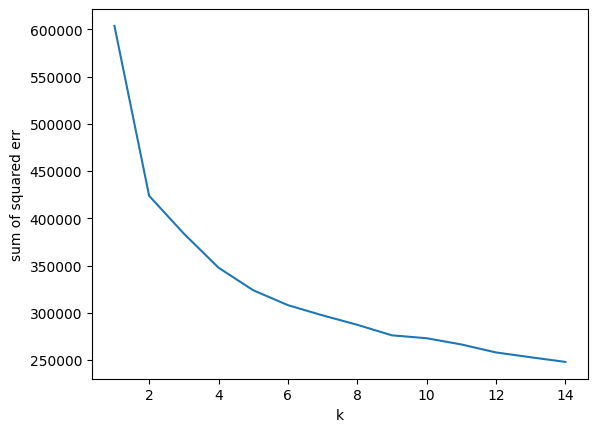

In [30]:
plt.plot(k_range,sse)
plt.ylabel('sum of squared err')
plt.xlabel('k')

In [38]:
clusterer = KMeans(n_clusters=5)
y_predicted = clusterer.fit_predict(df[df.columns.values])
df['class'] = y_predicted

In [39]:
df.head()

,month,day,hour,bx_gsm,by_gsm,bz_gsm,bt,speed,density,temp,intensity,declination,inclination,north,east,vertical,horizontal,class
0,-0.151583,-0.883816,-1.517247,3.453821,2.353381,2.893202,4.422568,0.0,0.0,0.0,-1.674089,0.788667,-1.694938,1.639882,1.695851,-1.691384,1.696862,2
1,-0.151583,-0.883816,-1.372752,3.233001,0.684281,2.229632,4.554325,0.0,0.0,0.0,-1.674089,0.788667,-1.694938,1.639882,1.695851,-1.691384,1.696862,2
2,-0.151583,-0.883816,-1.228256,2.398790,2.277513,2.580197,4.213307,0.0,0.0,0.0,-1.674089,0.788667,-1.694938,1.639882,1.695851,-1.691384,1.696862,2
3,-0.151583,-0.883816,-1.083761,2.705485,0.962465,2.004268,4.542699,0.0,0.0,0.0,-1.674089,0.788667,-1.694938,1.639882,1.695851,-1.691384,1.696862,2
4,-0.151583,-0.883816,-0.939266,2.432527,2.176355,0.927531,5.887395,0.0,0.0,0.0,-1.674089,0.788667,-1.694938,1.639882,1.695851,-1.691384,1.696862,2


In [40]:
# check distribution
df['class'].value_counts()

class
1    11570
0     8682
2     6621
4     4373
3     4265
Name: count, dtype: int64

In [41]:
grouped = df.groupby('class')

result = grouped.agg({'bx_gsm': ['mean', 'median'], 'by_gsm': ['mean', 'median'],
                       'bz_gsm': ['mean', 'median'], 'bt': ['mean', 'median'],
                       'vertical':['mean','median']})
# Rename the columns for clarity
result.columns = ['bx_mean', 'bx_median', 'by_mean',
                   'by_median', 'bz_mean', 'bz_median',
                     'bt_mean', 'bt_median','vt_mean','vt_median']
# Reset the index to make 'class'
result.reset_index(inplace=True)


In [42]:
print(result)

   class   bx_mean  bx_median  ...  bt_median   vt_mean  vt_median
0      0  0.044258   0.043373  ...  -0.526070  0.842525   0.834674
1      1  0.301863   0.393005  ...  -0.216053 -0.491186  -0.451319
2      2 -0.801566  -0.830708  ...   0.101714 -1.255991  -1.278029
3      3 -0.026361  -0.076238  ...  -0.088172  0.026110   0.007964
4      4  0.352802   0.389938  ...  -0.332309  1.503035   1.477671

[5 rows x 11 columns]


In [16]:
result['sum_of_medians'] = result['bx_median'] + result['by_median'] + \
    result['bz_median'] + result['bt_median'] + result['vt_median']

# Group by 'class' and calculate the sum
sum_of_medians = result.groupby('class')['sum_of_medians'].sum().reset_index()

sum_of_medians

,class,sum_of_medians
0,0,-0.200382
1,1,-0.513116
2,2,-1.865767
3,3,1.521299
4,4,-1.715058
5,5,5.287800
6,6,0.871725


In [17]:

df.to_csv('severity-classified-scaled.csv',index=False)

In [18]:
# Save the KMeans model to a .pkl file using pickle
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(clusterer, f)

In [21]:
# Properties of the scaler
print("Scaler Properties:")
print(f"mean: {scaler.mean_}")
print(f"std: {scaler.scale_}")


# Properties of the KMeans model
print("\nKMeans Model Properties:")
print(f"Number of clusters: {clusterer.n_clusters}")
print(f"Cluster Centers: \n{clusterer.cluster_centers_}")
print(f"Inertia: {clusterer.inertia_}")
print(f"Labels: {clusterer.labels_[:10]}")  # Displaying only the first 10 labels for brevity

Scaler Properties:
mean: [ 6.51910676e+00  1.57448678e+01  1.15003238e+01 -9.14200295e-02
  4.19419683e-01  1.05917242e+00  5.38752737e+00  4.31352471e+02
  6.90620884e+00  1.10481874e+05  5.73010901e+04  8.34558202e+01
  8.98419728e+01  1.53109459e+01  1.57149503e+02  5.73008266e+04
  1.57985272e+02]
std: [3.42457474e+00 8.76298845e+00 6.92064252e+00 3.26056832e+00
 3.95422687e-01 7.98709320e-01 2.58050827e+00 8.17870228e+01
 4.72746791e+00 9.56836246e+04 2.15580549e+01 2.43091268e+00
 7.72729289e-02 4.68878405e+00 7.71592011e+01 2.17730518e+01
 7.72100037e+01]

KMeans Model Properties:
Number of clusters: 7
Cluster Centers: 
[[ 1.86596912e-01  6.89971944e-03 -7.01483907e-03 -7.23796372e-02
   1.01463390e-01  4.32045603e-01  6.25670787e-02  2.02051889e+00
  -6.81656579e-01  1.80774196e+00 -1.93909751e-02  3.26536246e-01
  -1.67312939e-02  1.29303673e-02  1.72428725e-02 -1.87881909e-02
   1.72876380e-02]
 [ 2.49670281e-01  2.83125496e-02  3.92153170e-03  3.07413325e-02
  -1.86134780e-0

In [20]:
# Define the mapping dictionary
mapping = {0: 0, 3: 1, 2: 2, 4: 3, 1: 4}

# Function to apply the mapping
def map_value(value):
    return mapping.get(value, -1)  # Returns -1 if the value is not in the mapping

# Example usage
mapped_values = [map_value(v) for v in [0, 3, 2, 4, 1, 5]]
print(mapped_values)


[0, 1, 2, 3, 4, -1]
